In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import arviz as az
import corner
import time

In [2]:
data=pd.read_csv("JPN-HIV-AIDS.csv",header=None)

In [3]:
y_obs_tmp=data[[1,2]]
y_obs=y_obs_tmp.to_numpy()

In [4]:
#az.style.use("arviz-darkgrid")

NumIter = 10000
burnin  = 5000


save_results_to = 'JPN/'

times = np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
N=len(times)
small_times = np.linspace(0, N-1 ,10*N+1)


pred_days  = N+2
times_pred = np.linspace(0, pred_days,pred_days +1 ) 
times_pred_small = np.linspace(0, pred_days,(pred_days+1)*10 +1 ) 

pop = 126317000         # Population 

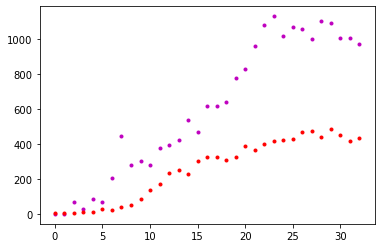

In [5]:
fig0= plt.figure()
plt.plot(times, y_obs[:,0],'m.', times, y_obs[:,1],'r.')
#plt.show()
plt.savefig( save_results_to + 'HIV-AIDS_cases.eps')

In [6]:
mydata = {}
mydata['n_obs']       = len(times)
mydata['n_small']     = len(small_times)
mydata['n_small_pred']= len(times_pred_small)
mydata['n_theta']     = 4
mydata['n_difeq']     = 3
mydata['n_pop']       = pop
mydata['y']           = y_obs
mydata['t0']          = -0.000001
mydata['n_fake']      = len(times_pred)
mydata['fake_ts']     = times_pred_small
mydata['tsm']         = small_times
mydata['ts']          = times

In [7]:
beta_mu = 0.
beta_sd = 1.5
beta_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 3
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 3
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

I0_low  = 0.
I0_high = 8e-5
I0_stan = 'uniform({mu}, {sd})'.format(mu=I0_low, sd=I0_high)


A0_low  = 0.
A0_high = 8e-5
A0_stan = 'uniform({mu}, {sd})'.format(mu=A0_low, sd=A0_high)

In [8]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ lognormal(0, 1.5);
  sigma    ~ uniform(0.0, 1.0 );
  Karga1   ~ uniform(0.0, 3 );
  Karga2   ~ uniform(0.0, 3);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [9]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2936407b2c7a2a644df34ea086c24d1 NOW.


--- 38.25465774536133 seconds ---


In [10]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 343.77492451667786 seconds ---


In [11]:
# start_time = time.time()
# fit = sm.vb(
#                   data=mydata,
#                   iter=50000,
#                   seed=431,
#                   sample_file = save_results_to + "advi_results.csv",    
#                   verbose=True,
#                   init='0',
# #                  algorithm='meanfield'
#                   algorithm='fullrank'
#                   )
# print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [13]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [14]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074208,0.000126,0.011273,1.051514,1.066646,1.074482,1.081833,1.095895,8056.469859,1.000279
sigma,0.915996,0.000104,0.009805,0.896340,0.909413,0.916149,0.922608,0.934846,8836.432003,1.000343
Karga1,0.036365,0.000012,0.001152,0.034210,0.035570,0.036324,0.037138,0.038680,8544.878281,1.000579
Karga2,0.016532,0.000006,0.000551,0.015496,0.016147,0.016515,0.016900,0.017651,8553.584054,1.000517
R_0,1.160313,0.000032,0.003262,1.154012,1.158096,1.160307,1.162508,1.166717,10427.668918,1.000731


In [15]:
# with open('Table_JPN.tex','w') as tf:
#      tf.write(df_summary.to_latex())

In [16]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

<Figure size 432x288 with 0 Axes>

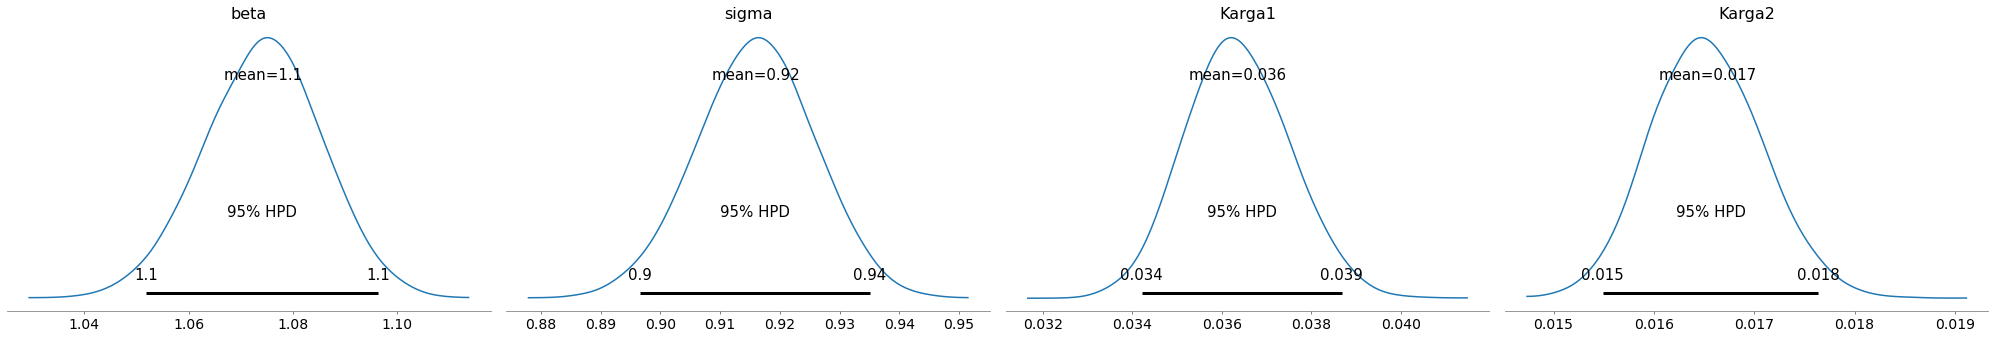

In [17]:
varnames = ["beta", "sigma", "Karga1", "Karga2"]
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credibleIntervalsAll_JPN.eps')

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

<Figure size 432x288 with 0 Axes>

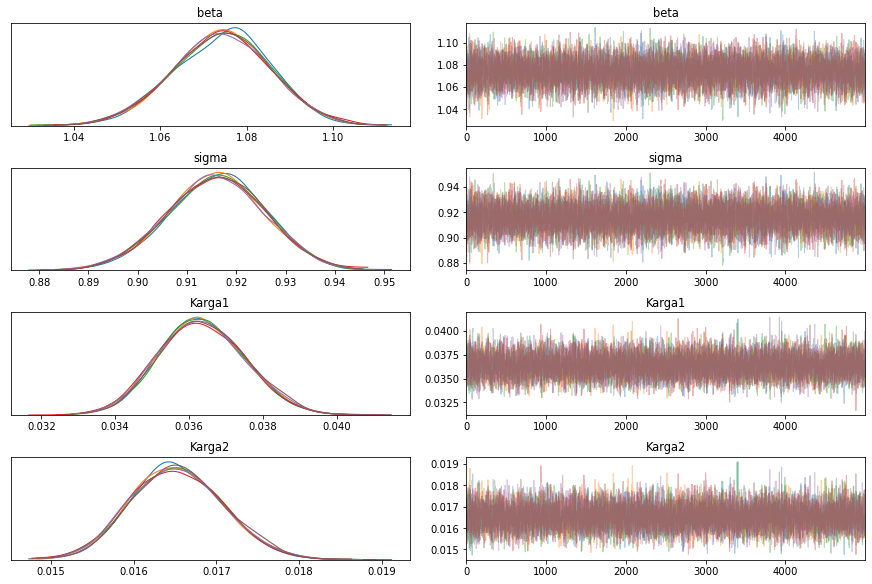

In [18]:
inference_data = az.from_pystan(fit)
plt.figure()
az.plot_trace(inference_data,var_names= varnames)
plt.savefig(save_results_to +'TraceAll_JPN.pdf')

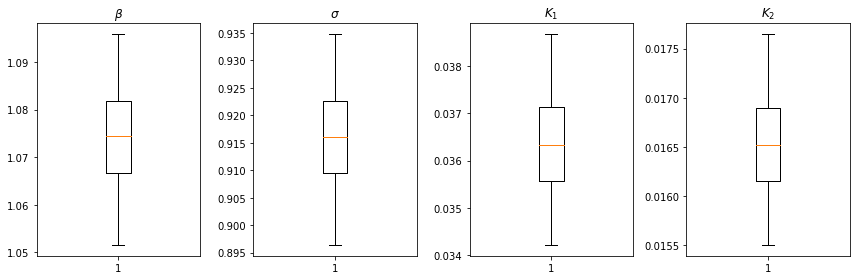

In [19]:
fig, axs = plt.subplots(1, 4,figsize=(12, 4))
axs[0].boxplot(fit_df['beta'],whis=(2.5,97.5), sym='')
axs[0].set_title(r'$\beta$')

axs[1].boxplot(fit_df['sigma'],whis=(2.5,97.5), sym='')
axs[1].set_title(r'$\sigma$')

axs[2].boxplot(fit_df['Karga1'],whis=(2.5,97.5), sym='')
axs[2].set_title(r'$K_1$')

axs[3].boxplot(fit_df['Karga2'],whis=(2.5,97.5), sym='')
axs[3].set_title(r'$K_2$')

plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_JPN.pdf')

In [20]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

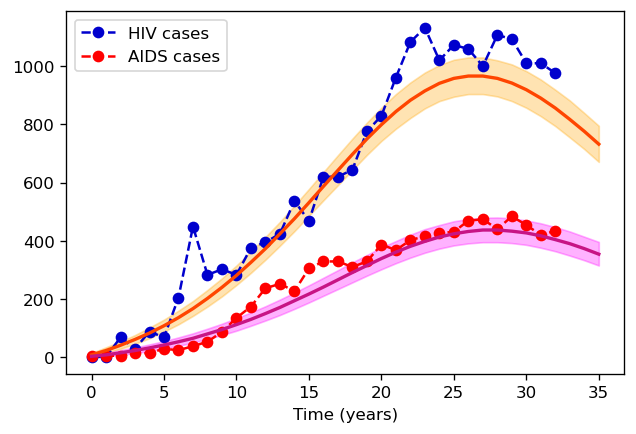

In [21]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1], color='magenta', alpha=0.3)
ax.set_xlabel('Time (years)')  # Add an x-label to the axes.
#ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands_JPN.pdf')

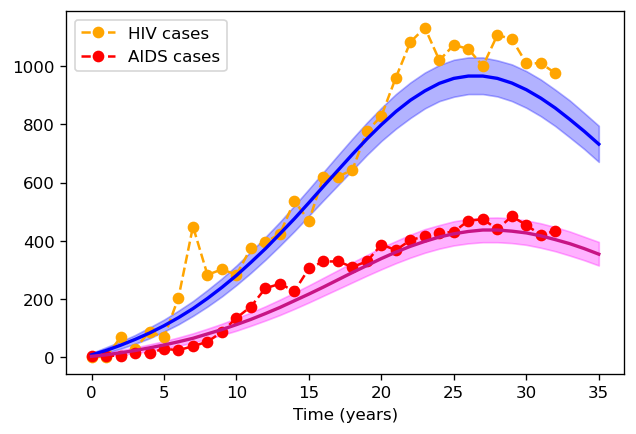

In [22]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='orange',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='b', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='b', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1],  color='magenta', alpha=0.3)
ax.set_xlabel('Time (years)')  # Add an x-label to the axes.
#ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands0_JPN.pdf')

In [23]:
pystan_trace = [fit_dict['beta'], fit_dict['sigma'], fit_dict['Karga1'],fit_dict['Karga2']]

In [24]:
trace=np.array(pystan_trace)
trace_df = pd.DataFrame(pystan_trace) 
map=np.median(trace,axis=1)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 432x288 with 0 Axes>

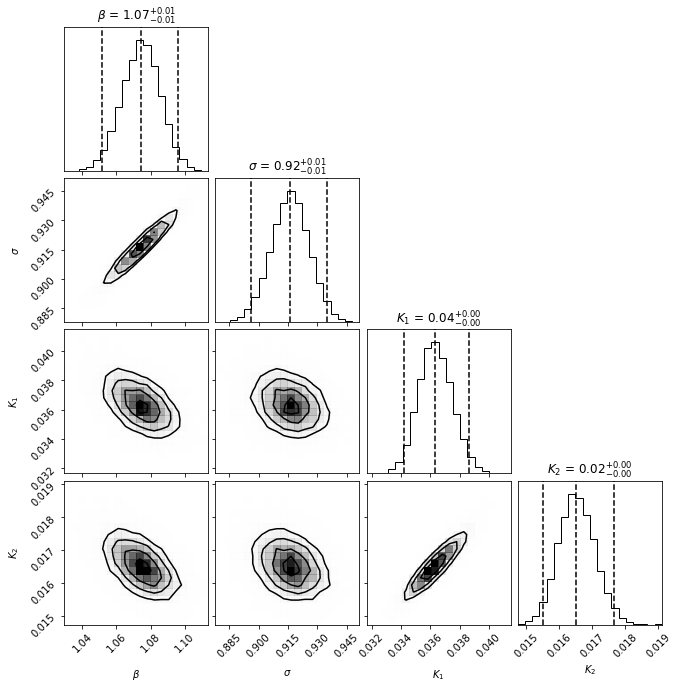

In [25]:
varnames=[r"$\beta$", r"$\sigma$" , r"$K_{1}$" , r"$K_{2}$"]
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975])
plt.savefig(save_results_to +'corner1_JPN.pdf')

<Figure size 432x288 with 0 Axes>

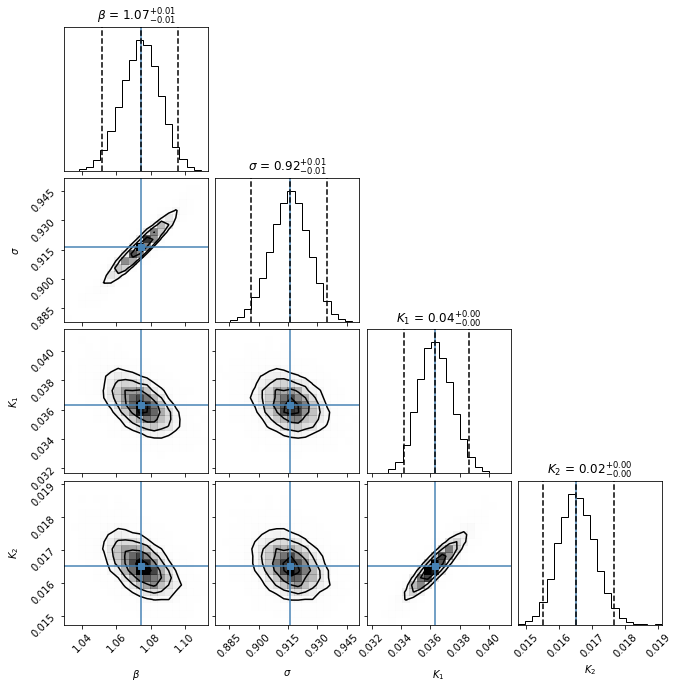

In [26]:
varnames=[r"$\beta$", r"$\sigma$" , r"$K_{1}$" , r"$K_{2}$"]
range = np.array([(0.1*x,1.9*x) for x in map])
#range=range
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,truths=map,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975])
plt.savefig(save_results_to +'corner2_JPN.pdf')

In [27]:
from IPython.display import display, Math
ppc_beta=np.percentile(fit_df['beta'],q=50,axis=0)
ppc_sigma=np.percentile(fit_df['sigma'],q=50,axis=0)
nu= 0.0073;
R_0 = ppc_beta/(ppc_sigma + nu)
display(Math(r'\beta: {}'.format(ppc_beta)))
display(Math(r'\sigma: {}'.format(ppc_sigma)))
display(Math(r'\nu: {}'.format(nu)))
print()
display(Math(r'R_0: {}'.format(R_0)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>